# Exploring CO₂ Emissions Through an Explainable Linear Model

In this notebook, my goal is not yet to chase the highest possible predictive score.  
Instead, I deliberately focus on a **high-interpretability model** — Lasso regression — to understand *which vehicle characteristics most strongly influence CO₂ emissions*.

The guiding motivation here is to reveal patterns that make mechanical sense and to use coefficients as a lens for interpreting how different design choices shape emissions.  
Prediction accuracy is useful, but explanation is the real priority.


## Importing Libraries

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Loading and Inspecting the Data

I begin by loading the dataset and associated lookup tables that help translate coded variables (such as transmission type and fuel type) into descriptive labels.  
Before modeling, I want a clear understanding of what information each column conveys and how it connects to real-world engineering concepts.

In [66]:
data = pd.read_csv("data/CO2 Emissions_Canada.csv")
trans_df = pd.read_csv("data/transmission_codes_full.csv")
code_map = dict(zip(trans_df["trans_code"], trans_df["trans_description"]))

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Vehicle Class        7385 non-null   object 
 1   Engine Size(L)       7385 non-null   float64
 2   Cylinders            7385 non-null   int64  
 3   Transmission         7385 non-null   object 
 4   Fuel Type            7385 non-null   object 
 5   CO2 Emissions(g/km)  7385 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 346.3+ KB


In [85]:
data.head()

,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,CO2 Emissions(g/km)
0,COMPACT,2.0,4,Automatic with select shift (5 gears),Premium gasoline,196
1,COMPACT,2.4,4,Manual (6 gears),Premium gasoline,221
2,COMPACT,1.5,4,Continuously variable (7 gears),Premium gasoline,136
3,SUV - SMALL,3.5,6,Automatic with select shift (6 gears),Premium gasoline,255
4,SUV - SMALL,3.5,6,Automatic with select shift (6 gears),Premium gasoline,244


## Data cleaning and engeenering

Because my objective is coefficient interpretation rather than maximizing predictive power, feature selection must reflect what information would be available **before** production.

This leads me to remove:
- Variables that contain **post-production measurements** (fuel consumption values)
- Redundant or almost uninformative/biased identifiers (Make, Model)
- Leakage variables that directly encode the target

In [68]:
non_informative_columns = ["Make", "Model"]
redundant_columns = ["Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
# The producer can't know fuel consumption in advance.
# It can only be mesured after the car is built.
leakage_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)"]
columns_to_drop = non_informative_columns + redundant_columns + leakage_variables
data.drop(columns=columns_to_drop, inplace=True)
data.isna().sum()

Vehicle Class          0
Engine Size(L)         0
Cylinders              0
Transmission           0
Fuel Type              0
CO2 Emissions(g/km)    0
dtype: int64

## Making Categorical Features Readable

Transmission and fuel type codes are not immediately interpretable.  
Before fitting a linear model, I translate these codes into human-readable descriptions.  
Interpretability starts here — a model is only as understandable as its inputs.

Both transformations allow downstream coefficients to be meaningfully interpreted rather than referring to opaque codes.


In [69]:
trans_split = data["Transmission"].astype(str).str.extract(
    r'^(?P<code>[A-Z]+)(?P<gears>\d*)$'
)
desc = trans_split["code"].map(code_map)
# Fall back to the original if some codes are missing
desc = desc.fillna(trans_split["code"])
gears = trans_split["gears"]
data["Transmission_full"] = np.where(
    gears.notna() & (gears != ""),
    desc + " (" + gears + " gears)",
    desc
)
data["Transmission"] = data["Transmission_full"]
data.drop(columns=["Transmission_full"], inplace=True)

data[["Transmission"]].head()

,Transmission
0,Automatic with select shift (5 gears)
1,Manual (6 gears)
2,Continuously variable (7 gears)
3,Automatic with select shift (6 gears)
4,Automatic with select shift (6 gears)


In [70]:
fuel_df = pd.read_csv("data/fuel_codes.csv")
fuel_map = dict(zip(fuel_df["fuel_code"], fuel_df["fuel_description"]))
fuel_desc = data["Fuel Type"].map(fuel_map)
# Fall back to original code if no match is found
fuel_desc = fuel_desc.fillna(data["Fuel Type"])
data["Fuel Type_full"] = fuel_desc
data["Fuel Type"] = fuel_desc
data.drop(columns=["Fuel Type_full"], inplace=True)

print(data[["Fuel Type"]].head())

          Fuel Type
0  Premium gasoline
1  Premium gasoline
2  Premium gasoline
3  Premium gasoline
4  Premium gasoline


## Choosing the Target and Splitting the Data

For this exploration, I choose **CO₂ Emissions (g/km)** as the target variable.  
All remaining columns are treated as input features.

I then perform a standard 80/20 train–test split.  
The test set is kept untouched during model fitting to later check how stable the patterns are outside the training data.

In [71]:
y_column = "CO2 Emissions(g/km)"
X = data.drop(y_column, axis=1)
y = data[[y_column]]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=123)

## Column Transformer: One-Hot Encoding + Normalization

Now I set up a **ColumnTransformer** to handle preprocessing in a structured way:

- **Categorical columns** (`Vehicle Class`, `Transmission`, `Fuel Type`)  
  → transformed with `OneHotEncoder`, expanding each category into a separate binary feature.

- **Numeric columns** (all others)  
  → transformed with `StandardScaler`, normalizing them to have roughly zero mean and unit variance.

This design has two advantages for an explainable Lasso model:

1. **Stability of coefficients**: scaling numeric features prevents L1 regularization from being dominated by variables with large natural scales (like engine size or weight).
2. **Comparability**: once features are on similar scales, the magnitude of coefficients becomes easier to compare, especially across numeric features.

The `ColumnTransformer` ensures that the same preprocessing is consistently applied to both training and test sets.


In [72]:
categorical_cols = ["Vehicle Class", "Transmission", "Fuel Type"]
numeric_cols = X.columns.difference(categorical_cols)
ohe_transformer = ("encoder", OneHotEncoder(handle_unknown='ignore', drop=None), categorical_cols) # drop=None, since unseen classes might meet in the test set.
sc_transformer = ('scaler', StandardScaler(), numeric_cols)
ct = ColumnTransformer(
    transformers=[ohe_transformer, sc_transformer], remainder="passthrough"
)

## Applying the Column Transformer

I now fit the transformer on the training data and apply it to both train and test sets.

From this point onward, the Lasso model operates in the **transformed feature space**:
- one-hot encoded categorical features
- normalized numeric features

In [73]:
X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)

## Exploring Lasso Regularization Strengths

With the data preprocessed, I explore several values of the L1 regularization parameter **alpha**.

The goal here is not to tune the model aggressively, but rather to:

- Ensure that the model is not wildly overfitting or underfitting
- See how stable the key relationships remain as alpha changes
- Choose a level of regularization that keeps the model **both** reasonably accurate and highly interpretable


In [74]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

train_r2_scores, test_r2_scores = [], []
best_alpha = None
best_r2 = -np.inf

for alpha in alpha_values:
    reg = linear_model.Lasso(alpha=alpha, max_iter=50000, random_state=123)
    reg.fit(X_train_transformed, y_train)
    
    train_r2 = reg.score(X_train_transformed, y_train)
    test_r2 = reg.score(X_test_transformed, y_test)
    
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    print(f"Alpha={alpha:<7} | Train R²={train_r2:.3f} | Test R²={test_r2:.3f}")
    
    r2_is_better = round(test_r2, 3) > round(best_r2, 3)
    r2_equal_but_alpha_larger = (
        round(test_r2, 3) == round(best_r2, 3)
        and (best_alpha is None or alpha > best_alpha)
    )
    if r2_is_better or r2_equal_but_alpha_larger:
        best_r2 = test_r2
        best_alpha = alpha
        best_reg = reg
        best_y_test_pred = reg.predict(X_test_transformed)

print(f"\n✅ Best alpha: {best_alpha:.4f} (Test R² = {best_r2:.3f})")

Alpha=0.0001  | Train R²=0.856 | Test R²=0.842
Alpha=0.001   | Train R²=0.856 | Test R²=0.842
Alpha=0.01    | Train R²=0.856 | Test R²=0.841
Alpha=0.1     | Train R²=0.849 | Test R²=0.833
Alpha=1.0     | Train R²=0.768 | Test R²=0.753
Alpha=10.0    | Train R²=0.710 | Test R²=0.694

✅ Best alpha: 0.0010 (Test R² = 0.842)


<span style="color:#2a9d8f;">
  
| `Alpha (α)` | Training R² | Test R² |
| -- | -- | -- |
| 0.0001 | 0.856 | 0.842 |
| 0.001 | 0.856 | 0.842 |
| 0.01 | 0.856 | 0.841 |
| 0.1 | 0.849 | 0.833 |
| 1.0 | 0.768 | 0.753 |
| 10.0 | 0.710 | 0.694 |

</span>

From these scores, very small α values (around 0.0001–0.01) give the best and most balanced performance, with training and test R² values almost identical (≈0.856 vs. ≈0.842).  
This already suggests something striking about the dataset: **regularization barely improves anything**. The moment α is increased, the model does not get more stable — it simply loses explanatory power.

As α increases beyond 0.01, both R² values start to decline.  
This indicates that stronger regularization begins to oversimplify the model, pushing it toward **underfitting** and reducing its explanatory richness.

<div style="color:#7b3f70;">

This behavior reveals an important property of the data itself:  
the dataset is <strong>clean, low-noise, and already high quality</strong>, especially after dropping leakage and uninformative columns.  
There are also <strong>very few numerical features (only around five core continuous variables)</strong>, so the model is already simple, and penalizing coefficients does not help control variance — because there wasn’t excessive variance to begin with.  
Regularization would likely be beneficial only if the dataset contained noisy, redundant, or biased columns, but here there is essentially <strong>nothing harmful to penalize</strong>.

</div>


Mild regularization around **α = 0.001** seems to strike a good balance:
- The model is not overly complex.
- The performance is solid.
- Coefficients remain rich enough to tell an interesting story about the data.



## Checking Error Magnitude (RMSE)

To make sure that the model is not so inaccurate that its coefficients become misleading, I compute the **root mean squared error (RMSE)** on the test set.

This provides a rough sense of how far, on average, the predictions are from the true CO₂ emission values.


In [88]:
best_alpha = alpha_values[1]

test_rmse = metrics.root_mean_squared_error(y_test, best_y_test_pred)
avg_co2 = y_test.mean().item()

print(f"\n✅ For the best performing alpha = 0.001")
print(f"Test RMSE = {test_rmse:.3f} (g/km)")
print(f"Average CO₂ emission in test set = {avg_co2:.1f} g/km")
print(f"Relative error = {100 * test_rmse / avg_co2:.2f}%")


✅ For the best performing alpha = 0.001
Test RMSE = 23.633 (g/km)
Average CO₂ emission in test set = 250.7 g/km
Relative error = 9.43%


The model’s test RMSE of 23.6 g/km means that, on average, its predictions differ from the true CO₂ emissions by about 24 grams per kilometer.
Given that the average CO₂ emission in the test set is ≈250.7 g/km, this corresponds to a relative error of about 9.4%.

In the context of real vehicle emission data—where values can vary substantially across engine types, sizes, and technologies—a ~10% error is reasonable for an **interpretation-focused** model. It indicates that the model captures the main drivers of CO₂ emissions while maintaining enough simplicity (via regularization) to remain interpretable, even though it does not aim for perfect predictive accuracy.

## Interpreting the Coefficients — Core of the Analysis

Now comes the central part of the notebook: understanding **what the model has learned**.

Because I used a `ColumnTransformer`, the model’s coefficients correspond to the transformed feature space.  
I retrieve the feature names from the transformer to match each coefficient to its feature.

- For **categorical features**, each coefficient corresponds to a specific category (e.g., a certain vehicle class, a particular fuel type, or transmission configuration).
- For **numeric features**, coefficients now describe the effect of a **one standard deviation change** in that feature (due to `StandardScaler`) on CO₂ emissions, all else equal.


In [80]:
coefficients = pd.DataFrame({"column" : ct.get_feature_names_out(), "coefficient" : best_reg.coef_}).sort_values("coefficient")

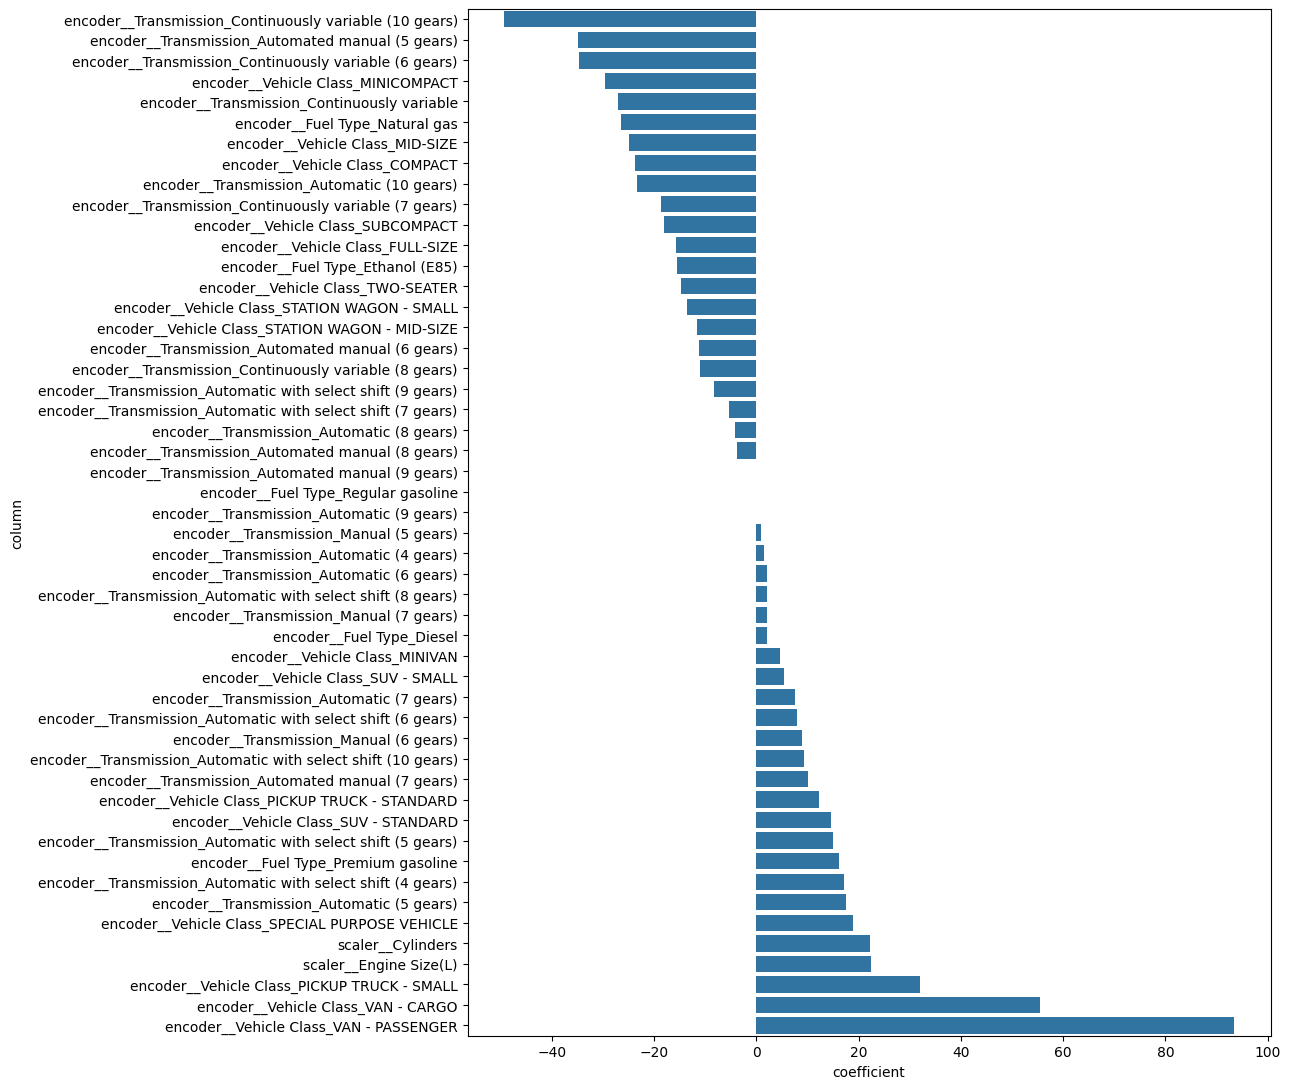

In [81]:
plt.figure(figsize=(13, 11))
sns.barplot(data=coefficients, x="coefficient", y="column")
plt.tight_layout()
plt.show()

### What the Coefficients Suggest

Even without focusing on exact numbers, several clear patterns emerge:

- **Vehicle Class**  
  Larger and heavier classes (like vans and pickup trucks) show strong positive coefficients, indicating higher CO₂ emissions relative to the baseline classes.  
  This matches the intuitive expectation that heavier and more utility-oriented vehicles require more energy per kilometer.

- **Engine-related features**  
  Engine size and cylinder count remain strong positive contributors even after standardization.  
  A one-standard-deviation increase in engine size is associated with a notable increase in emissions, reflecting the basic physics of fuel consumption.

- **Fuel Type**  
  Some fuel types associated with high-performance engines (e.g., premium gasoline) tend to increase emissions, consistent with engines tuned more for power than for efficiency.

- **Transmission Type**  
  Certain advanced transmission technologies (like continuously variable transmissions and some automated manuals) show negative coefficients relative to more traditional transmissions.  
  This suggests they help reduce emissions by keeping the engine in more efficient operating regions.

Overall, the model tells a coherent story:

> Emissions tend to rise with vehicle size and power, and tend to fall with more efficiency-oriented transmission designs.  
> Fuel choice further modulates this balance, especially where high-performance tuning is involved.


## Visualizing a Key Relationship: Engine Size vs CO₂

To cross-check one of the strongest relationships suggested by the coefficients, I visualize **Engine Size (L)** against the target CO₂ emissions.

Even though the model operates on standardized features, plotting the raw engine size against the raw CO₂ values is more intuitive and still consistent with the sign of the coefficient.


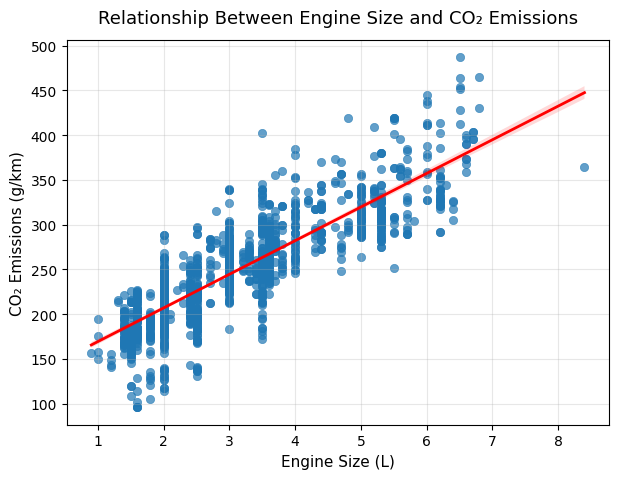

In [ ]:
# Scatter plot of Engine Size
# (highest-magnitude coefficient ❗NUMERIC❗ independent variable)
# vs CO2 Emissions
plt.figure(figsize=(7,5))
sns.scatterplot(x=np.ravel(X_test["Engine Size(L)"]), y=np.ravel(y_test), alpha=0.7, edgecolor=None)
sns.regplot(x=X_test["Engine Size(L)"], y=y_test, scatter=False, color="red", line_kws={"linewidth":2})

plt.title("Relationship Between Engine Size and CO₂ Emissions", fontsize=13, pad=12)
plt.xlabel("Engine Size (L)", fontsize=11)
plt.ylabel("CO₂ Emissions (g/km)", fontsize=11)
plt.grid(alpha=0.3)
plt.show()

The plot shows a clear upward trend: larger engines are associated with higher CO₂ emissions.  
This visual pattern aligns well with the positive coefficient learned by the Lasso model, reinforcing the idea that the model is capturing a genuine mechanical relationship rather than noise.

## Final Reflections

This notebook deliberately prioritizes **interpretability** over squeezing out every last bit of predictive performance.

Key design choices that support this goal:

- Dropping leakage variables so coefficients reflect design, not hidden measurements
- Translating categorical codes to readable labels
- Using a `ColumnTransformer` to:
  - One-hot encode categorical features
  - Normalize numeric features with `StandardScaler`
- Applying Lasso regression with mild regularization to:
  - Control complexity
  - Encourage sparsity
  - Keep coefficients stable and understandable

The resulting model:

- Achieves reasonable predictive performance (R² and RMSE are acceptable)
- Produces coefficients that align with domain intuition
- Provides a clear narrative about how different design decisions (vehicle class, engine size, fuel type, transmission type) shape CO₂ emissions

For exploratory, explanation-driven analysis of vehicle emissions, this setup feels like a good balance between **mathematical rigor**, **engineering intuition**, and **model transparency**.
